In [49]:
# Install required packages if not already installed
import subprocess
import sys

def install_package(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install packages
packages = ["yfinance", "pandas", "numpy", "matplotlib", "scipy", "scikit-learn", "seaborn", "arch"]
for package in packages:
    install_package(package)

print("All packages installed and ready.")


All packages installed and ready.


In [50]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from arch import arch_model

plt.style.use("default")

# Inputs
TICKER = "NUE"
MARKET = "SPY"
PEERS = ["STLD", "CLF", "SLX"]
START_DATE = "2015-01-01"
END_DATE = None
TRADING_DAYS = 252
RISK_FREE = 0.045 # 1 year yield of US treasury bonds (update with current rate)

print("Setup complete.")

Setup complete.


In [51]:
#Basically just data downloading and formatting
tickers = [TICKER, MARKET] + PEERS

data = yf.download(
    tickers,
    start=START_DATE,
    end=END_DATE,
    progress=False,
    group_by='ticker',
    auto_adjust=True
)

# Error handling: Check if data download was successful
if data.empty:
    raise ValueError("Data download failed - no data returned")

if isinstance(data.columns, pd.MultiIndex):
    data = data.xs('Close', axis=1, level=1)

if isinstance(data, pd.Series):
    data = data.to_frame(name=TICKER)

data = data.dropna(how="all")

# Validate that required columns exist
required_cols = [TICKER, MARKET] + PEERS
missing_cols = [col for col in required_cols if col not in data.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

nue_price = data[TICKER]
spy_price = data[MARKET]
peer_prices = data[PEERS]

print("Data downloaded.")
display(data.tail())

Data downloaded.


Ticker,SLX,STLD,SPY,NUE,CLF
Date,,,,,
2025-11-03,78.940002,155.970001,683.340027,148.119995,11.87
2025-11-04,76.239998,151.619995,675.239990,144.289993,10.68
2025-11-05,77.150002,154.130005,677.580017,145.250000,10.51
2025-11-06,77.510002,152.919998,670.309998,144.660004,10.09
2025-11-07,78.040001,151.940002,670.969971,144.309998,10.43


In [52]:
# Daily simple returns
nue_ret = nue_price.pct_change() #NUCOR's returns
spy_ret = spy_price.pct_change() #S&P500's returns
peer_ret = peer_prices.pct_change() #Competition/Market returns

# Combination of all returns with proper index alignment
returns = pd.DataFrame({
    TICKER: nue_ret,
    MARKET: spy_ret
}).join(peer_ret, how='inner').dropna()

# Calculate daily risk-free rate
daily_rf = RISK_FREE / TRADING_DAYS

# Calculate excess returns (returns minus risk-free rate) for proper CAPM analysis
excess_returns = returns - daily_rf

print("Return series created.")
print("Excess returns (for CAPM analysis) calculated.")
returns.tail()

Return series created.
Excess returns (for CAPM analysis) calculated.


,NUE,SPY,STLD,CLF,SLX
Date,,,,,
2025-11-03,-0.012862,0.001877,-0.005293,-0.045052,-0.005292
2025-11-04,-0.025857,-0.011854,-0.027890,-0.100253,-0.034203
2025-11-05,0.006653,0.003465,0.016555,-0.015918,0.011936
2025-11-06,-0.004062,-0.010729,-0.007851,-0.039962,0.004666
2025-11-07,-0.002420,0.000985,-0.006409,0.033697,0.006838


In [53]:
# Function to calculate the annualized return from a series of returns.
# It compounds total return over the period and scales it to one year
# Basically, if the stock continued to perform like it did during the year, what would its annual return look like...

def annualized_return(r: pd.Series) -> float:
    return (1 + r).prod()**(TRADING_DAYS / len(r)) - 1

# Calculates annualized volatility, basically the standard deviation of returns...

def annualized_vol(r: pd.Series) -> float:
    return r.std() * np.sqrt(TRADING_DAYS)

# Risk adjusted return of a stock
# Sharpe = (Annualized Return - Risk-Free Rate) / Annualized Volatility
# Measures how efficiently a stock converts its risk into returns

def sharpe_ratio(r: pd.Series, rf: float = RISK_FREE) -> float:
    ar = annualized_return(r)
    av = annualized_vol(r)
    if av == 0:
        return np.nan
    return (ar - rf) / av

#Calculates the Maximum Drawdown: the worst observed peak-to-trough decline.
#The biggest percentage loss an investor would have faced if they bought at the highest point and held through the lowest point.
#Basically, what would my returns be if I bought in the worst possible moment and kept until the next crash

def max_drawdown(price: pd.Series) -> float:
    cummax = price.cummax()
    dd = (price - cummax) / cummax
    return dd.min()

# Sortino Ratio: Similar to Sharpe but only penalizes downside volatility
# Uses downside deviation instead of total volatility
# Better measure for investors concerned about downside risk

def sortino_ratio(r: pd.Series, rf: float = RISK_FREE) -> float:
    ar = annualized_return(r)
    # Calculate downside deviation (only negative returns)
    downside_returns = r[r < 0]
    if len(downside_returns) == 0:
        return np.nan
    downside_dev = downside_returns.std() * np.sqrt(TRADING_DAYS)
    if downside_dev == 0:
        return np.nan
    return (ar - rf) / downside_dev

# Conditional Value at Risk (CVaR): Expected loss beyond VaR threshold
# Also known as Expected Shortfall - measures tail risk more comprehensively than VaR
# Answers: "If we hit the VaR threshold, what's the average loss beyond that?"

def cvar(r: pd.Series, alpha: float = 0.05) -> float:
    var = r.quantile(alpha)
    # Average of returns below VaR threshold
    tail_returns = r[r <= var]
    if len(tail_returns) == 0:
        return np.nan
    return tail_returns.mean()

# Win Rate: Percentage of positive return periods
# Measures consistency of positive returns

def win_rate(r: pd.Series) -> float:
    if len(r) == 0:
        return np.nan
    return (r > 0).sum() / len(r)

# Calmar Ratio: Annualized Return / Maximum Drawdown
# Measures return per unit of worst-case risk
# Higher is better - shows how much return you get for the worst drawdown experienced

def calmar_ratio(r: pd.Series, price: pd.Series) -> float:
    ar = annualized_return(r)
    md = abs(max_drawdown(price))
    if md == 0:
        return np.nan
    return ar / md

print("Helper functions ready.")

Helper functions ready.


Correlation Matrix (Daily Returns):


,NUE,SPY,STLD,CLF,SLX
NUE,1.000,0.600,0.862,0.593,0.780
SPY,0.600,1.000,0.572,0.413,0.679
STLD,0.862,0.572,1.000,0.584,0.782
CLF,0.593,0.413,0.584,1.000,0.699
SLX,0.780,0.679,0.782,0.699,1.000


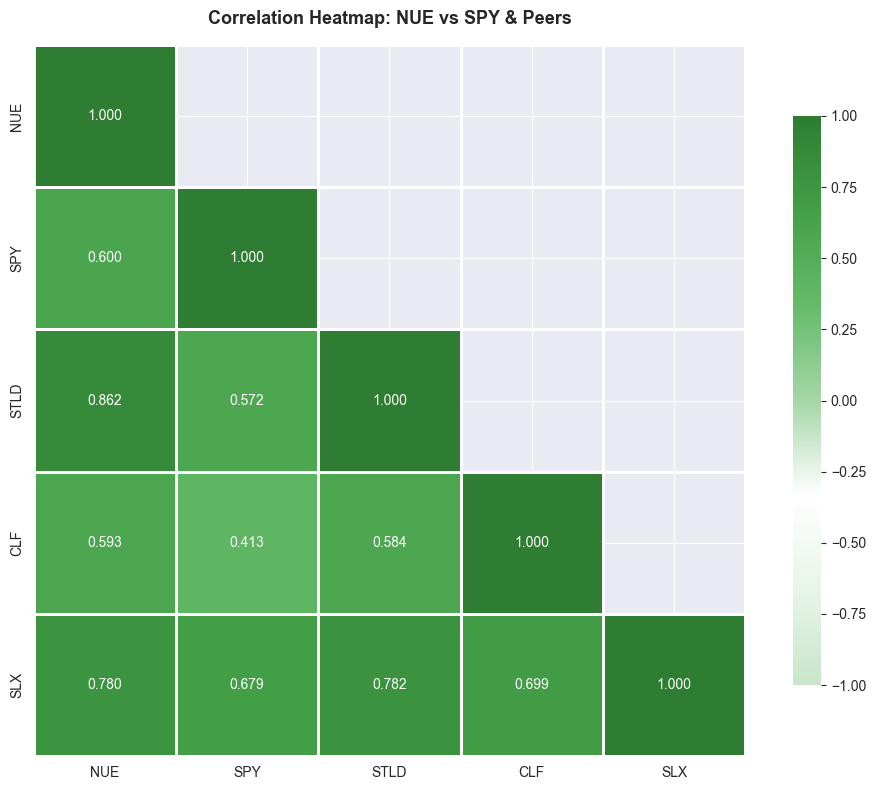


NUE Correlation Analysis:
Correlation with SPY: 0.600
Correlation with STLD: 0.862
Correlation with CLF: 0.593
Correlation with SLX: 0.780

Average correlation with peers: 0.745
Lower correlation indicates better diversification potential


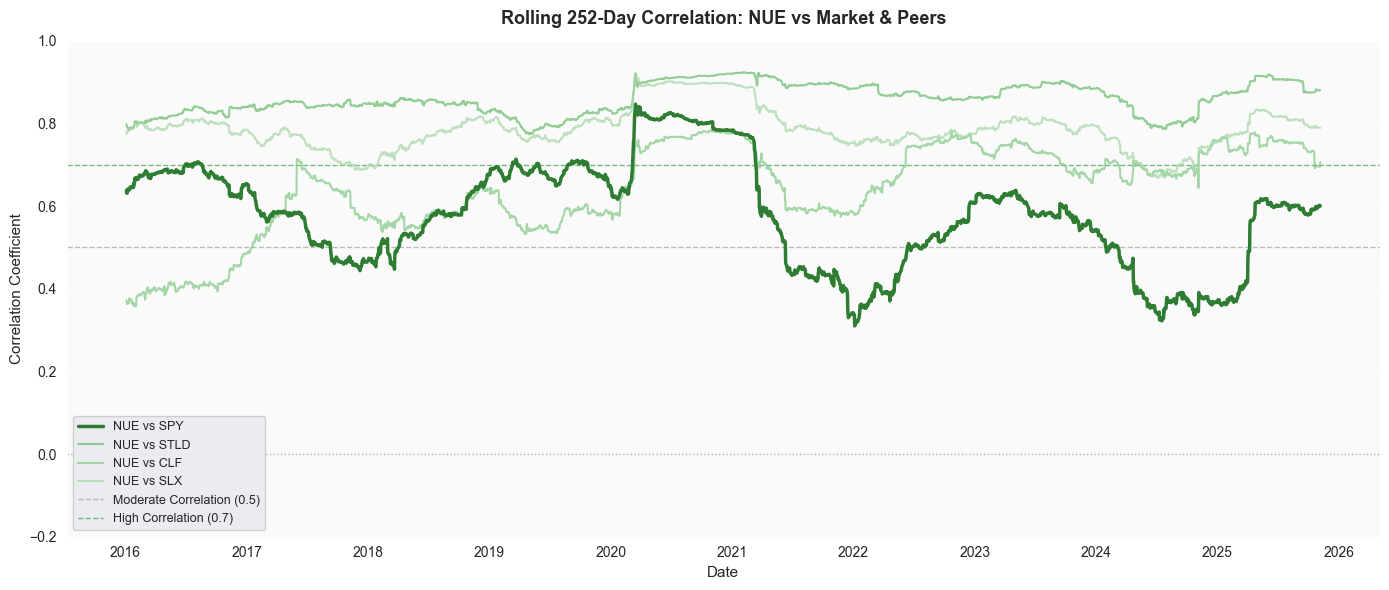


Average rolling correlation with SPY: 0.576
Average rolling correlation with STLD: 0.859
Average rolling correlation with CLF: 0.641
Average rolling correlation with SLX: 0.785


In [61]:
# Correlation Analysis & Diversification Benefits
# Understanding how NUE correlates with market and peers helps assess diversification benefits

# Create custom green-based diverging colormap for correlation matrix
from matplotlib.colors import LinearSegmentedColormap
# Green diverging colormap: light green for negative, white for zero, dark green for positive
colors_green = ['#C8E6C9', '#E8F5E9', '#FFFFFF', '#A5D6A7', '#66BB6A', '#43A047', '#2E7D32']
n_bins = 256
green_cmap = LinearSegmentedColormap.from_list('green_div', colors_green, N=n_bins)

# Calculate correlation matrix
correlation_matrix = returns[[TICKER, MARKET] + PEERS].corr()

print("Correlation Matrix (Daily Returns):")
display(
    correlation_matrix.style.format("{:.3f}")
    .background_gradient(cmap=green_cmap, vmin=-1, vmax=1, axis=None)
    .set_caption("Correlation Matrix: NUE vs SPY & Peers")
)

# Visualize correlation matrix as heatmap
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)  # Mask upper triangle
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap=green_cmap, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, 
            vmin=-1, vmax=1, mask=mask, ax=ax)
ax.set_title("Correlation Heatmap: NUE vs SPY & Peers", fontsize=13, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

# Analyze NUE's correlation with market and peers
print("\nNUE Correlation Analysis:")
print(f"Correlation with {MARKET}: {correlation_matrix.loc[TICKER, MARKET]:.3f}")
for peer in PEERS:
    if peer in correlation_matrix.columns:
        print(f"Correlation with {peer}: {correlation_matrix.loc[TICKER, peer]:.3f}")

# Diversification benefit: Lower correlation = better diversification
avg_corr_with_peers = correlation_matrix.loc[TICKER, PEERS].mean()
print(f"\nAverage correlation with peers: {avg_corr_with_peers:.3f}")
print(f"Lower correlation indicates better diversification potential")

# Rolling correlation analysis (how correlation changes over time)
window_corr = 252  # 1 year rolling window
rolling_corr_market = returns[TICKER].rolling(window_corr).corr(returns[MARKET])
rolling_corr_peers = {}
for peer in PEERS:
    if peer in returns.columns:
        rolling_corr_peers[peer] = returns[TICKER].rolling(window_corr).corr(returns[peer])

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(rolling_corr_market.index, rolling_corr_market, 
        label=f'{TICKER} vs {MARKET}', linewidth=2.5, color='#2E7D32', zorder=5)

colors_peers_corr = ['#66BB6A', '#81C784', '#A5D6A7']
for i, (peer, corr_series) in enumerate(rolling_corr_peers.items()):
    ax.plot(corr_series.index, corr_series, 
            label=f'{TICKER} vs {peer}', alpha=0.7, linewidth=1.5,
            color=colors_peers_corr[i % len(colors_peers_corr)], zorder=3)

ax.axhline(0, color='black', linestyle=':', linewidth=1, alpha=0.3)
ax.axhline(0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Moderate Correlation (0.5)')
ax.axhline(0.7, color='#43A047', linestyle='--', linewidth=1, alpha=0.7, label='High Correlation (0.7)')

ax.set_title(f"Rolling {window_corr}-Day Correlation: NUE vs Market & Peers", 
             fontsize=13, fontweight='bold', pad=12)
ax.set_xlabel("Date", fontsize=11)
ax.set_ylabel("Correlation Coefficient", fontsize=11)
ax.legend(loc='best', fontsize=9, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_facecolor('#FAFAFA')
ax.set_ylim([-0.2, 1.0])

plt.tight_layout()
plt.show()

print(f"\nAverage rolling correlation with {MARKET}: {rolling_corr_market.mean():.3f}")
for peer, corr_series in rolling_corr_peers.items():
    print(f"Average rolling correlation with {peer}: {corr_series.mean():.3f}")


Fitting GARCH(1,1) model to NUE returns...

GARCH(1,1) Model Summary:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    NUE   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5919.38
Distribution:                  Normal   AIC:                           11846.8
Method:            Maximum Likelihood   BIC:                           11870.4
                                        No. Observations:                 2729
Date:                Sun, Nov 09 2025   Df Residuals:                     2728
Time:                        15:42:27   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
-------------------------------------------------------------------

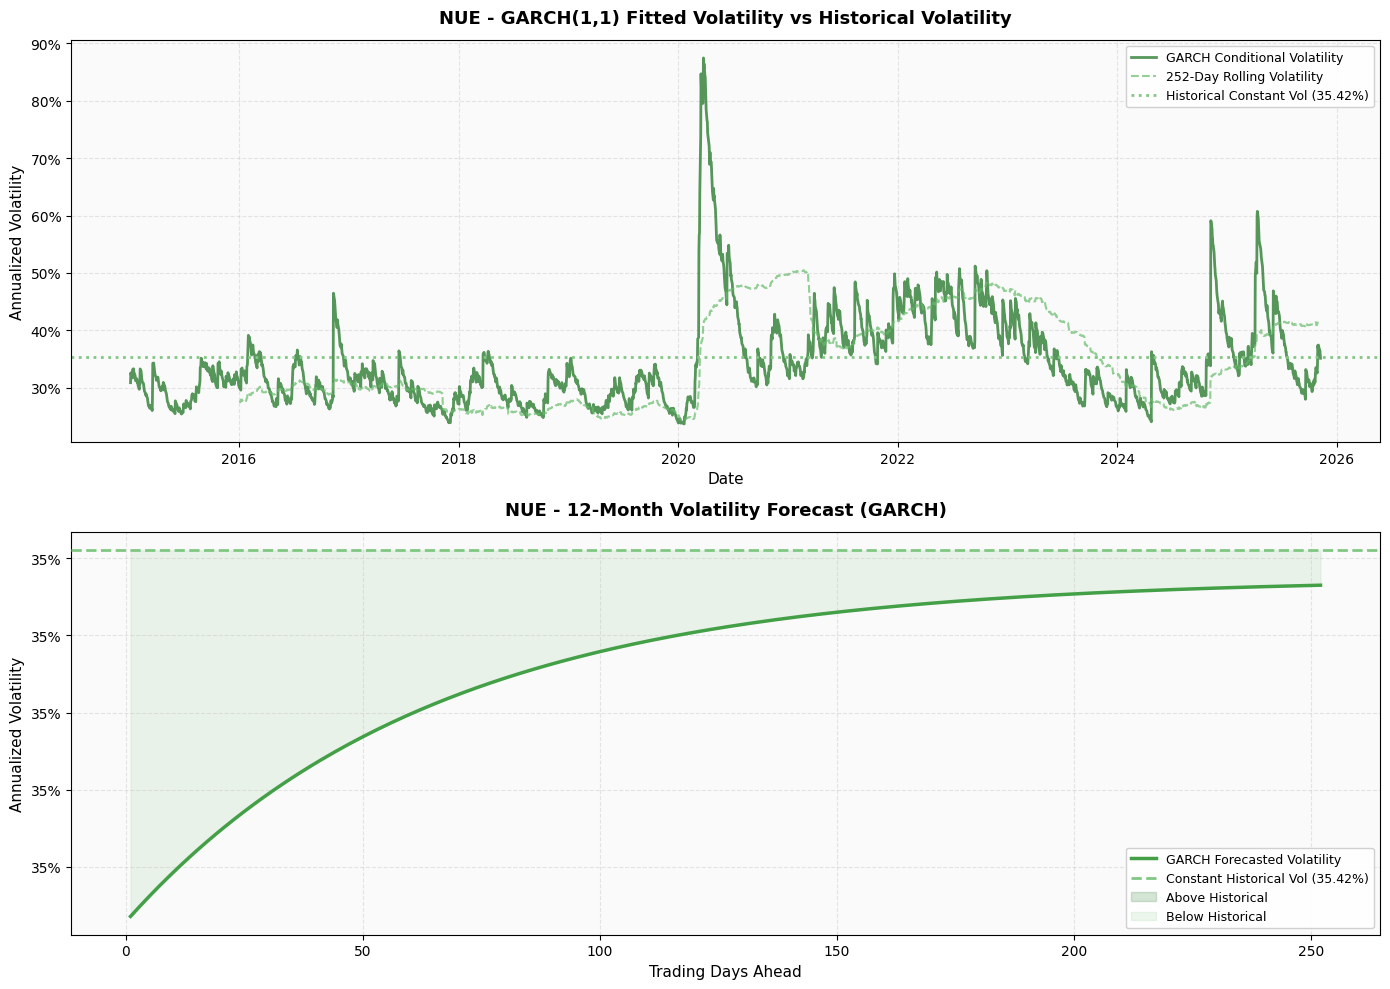


GARCH model fitted successfully. Volatility forecasts ready for Monte Carlo simulation.


In [55]:
# Fit GARCH(1,1) model for volatility forecasting
# GARCH models capture volatility clustering and time-varying volatility

# Prepare returns data for GARCH model
nue_returns_for_garch = returns[TICKER].dropna() * 100  # Convert to percentage for arch library

# Fit GARCH(1,1) model
# vol='GARCH' specifies GARCH model, p=1, q=1 specifies GARCH(1,1)
print("Fitting GARCH(1,1) model to NUE returns...")
garch_model = arch_model(nue_returns_for_garch, vol='GARCH', p=1, q=1, dist='normal')
garch_fitted = garch_model.fit(disp='off')

# Display model summary
print("\nGARCH(1,1) Model Summary:")
print("="*80)
print(garch_fitted.summary())

# Extract model parameters
garch_params = garch_fitted.params
omega = garch_params['omega']
alpha = garch_params['alpha[1]']
beta = garch_params['beta[1]']

print(f"\nGARCH(1,1) Parameters:")
print(f"  Omega (constant):     {omega:.6f}")
print(f"  Alpha (ARCH term):   {alpha:.6f}")
print(f"  Beta (GARCH term):   {beta:.6f}")
print(f"  Persistence (α+β):   {alpha + beta:.6f}")
print(f"\nModel Diagnostics:")
print(f"  AIC:  {garch_fitted.aic:.2f}")
print(f"  BIC:  {garch_fitted.bic:.2f}")
print(f"  Log Likelihood: {garch_fitted.loglikelihood:.2f}")

# Get in-sample conditional volatility (annualized)
conditional_vol = garch_fitted.conditional_volatility / 100  # Convert back from percentage
conditional_vol_annualized = conditional_vol * np.sqrt(TRADING_DAYS)

# Forecast volatility for the next 252 trading days (12 months)
print(f"\nForecasting volatility for {TRADING_DAYS} days ahead...")
garch_forecast = garch_fitted.forecast(horizon=TRADING_DAYS, reindex=False)

# Extract variance forecast (returns DataFrame with columns h.1, h.2, ..., h.252)
# Get the first row which contains the forecast starting from the last observation
forecasted_variance = garch_forecast.variance.iloc[-1].values / (100**2)  # Convert from percentage^2 to decimal^2
forecasted_vol_daily = np.sqrt(forecasted_variance)  # Daily volatility
forecasted_vol_annualized = forecasted_vol_daily * np.sqrt(TRADING_DAYS)  # Annualized

# Store daily volatility forecasts for Monte Carlo simulation
garch_vol_daily_forecast = forecasted_vol_daily

# Compare with historical constant volatility
hist_annual_vol = annualized_vol(returns[TICKER])
avg_garch_forecast_vol = forecasted_vol_annualized.mean()

print(f"\nVolatility Comparison:")
print(f"  Historical Constant Volatility: {hist_annual_vol:.2%}")
print(f"  Average GARCH Forecasted Vol:   {avg_garch_forecast_vol:.2%}")
print(f"  Difference:                     {avg_garch_forecast_vol - hist_annual_vol:+.2%}")

# Visualize GARCH fitted volatility vs historical rolling volatility
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Top panel: In-sample conditional volatility vs rolling volatility
rolling_vol_252 = returns[TICKER].rolling(252).std() * np.sqrt(TRADING_DAYS)
vol_dates = returns[TICKER].index[returns[TICKER].notna()]

ax1.plot(vol_dates, conditional_vol_annualized, label='GARCH Conditional Volatility', 
         linewidth=2, color='#2E7D32', alpha=0.8)
ax1.plot(rolling_vol_252.index, rolling_vol_252.values, label='252-Day Rolling Volatility', 
         linewidth=1.5, color='#66BB6A', alpha=0.7, linestyle='--')
ax1.axhline(hist_annual_vol, label=f'Historical Constant Vol ({hist_annual_vol:.2%})', 
           color='#81C784', linewidth=2, linestyle=':')
ax1.set_title(f'{TICKER} - GARCH(1,1) Fitted Volatility vs Historical Volatility', 
             fontsize=13, fontweight='bold', pad=12)
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Annualized Volatility', fontsize=11)
ax1.legend(loc='best', fontsize=9, framealpha=0.9)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_facecolor('#FAFAFA')
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Bottom panel: Forecasted volatility path for next 12 months
forecast_days = np.arange(1, TRADING_DAYS + 1)
ax2.plot(forecast_days, forecasted_vol_annualized, linewidth=2.5, color='#43A047', 
         label='GARCH Forecasted Volatility', zorder=5)
ax2.axhline(hist_annual_vol, label=f'Constant Historical Vol ({hist_annual_vol:.2%})', 
           color='#81C784', linewidth=2, linestyle='--', zorder=4)
ax2.fill_between(forecast_days, forecasted_vol_annualized, hist_annual_vol, 
                 where=(forecasted_vol_annualized >= hist_annual_vol), 
                 alpha=0.2, color='#2E7D32', label='Above Historical')
ax2.fill_between(forecast_days, forecasted_vol_annualized, hist_annual_vol, 
                 where=(forecasted_vol_annualized < hist_annual_vol), 
                 alpha=0.2, color='#A5D6A7', label='Below Historical')
ax2.set_title(f'{TICKER} - 12-Month Volatility Forecast (GARCH)', 
             fontsize=13, fontweight='bold', pad=12)
ax2.set_xlabel('Trading Days Ahead', fontsize=11)
ax2.set_ylabel('Annualized Volatility', fontsize=11)
ax2.legend(loc='best', fontsize=9, framealpha=0.9)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_facecolor('#FAFAFA')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
plt.show()

print("\nGARCH model fitted successfully. Volatility forecasts ready for Monte Carlo simulation.")


In [56]:
# Current price
current_price = nue_price.iloc[-1]

horizon_years = 1
days = TRADING_DAYS

# Historical annualized return (used for Monte Carlo forecast)
hist_annual_return = annualized_return(returns[TICKER])

# Use historical annualized return for Monte Carlo simulation
# This will forecast the 12-month price target based on historical performance
expected_annual_return = hist_annual_return

# Historical vol for reference (Monte Carlo will use GARCH-forecasted volatility)
hist_annual_vol = annualized_vol(returns[TICKER])

print(f"Current {TICKER} price: ${current_price:.2f}")
print(f"\nHistorical annualized return: {hist_annual_return:.2%}")
print(f"Historical annualized volatility: {hist_annual_vol:.2%}")
print(f"\nUsing historical return ({hist_annual_return:.2%}) and GARCH-forecasted volatility for Monte Carlo simulation")
print("The simulation will forecast the 12-month price target using time-varying volatility from GARCH model.")

Current NUE price: $144.31

Historical annualized return: 13.16%
Historical annualized volatility: 35.42%

Using historical return (13.16%) and GARCH-forecasted volatility for Monte Carlo simulation
The simulation will forecast the 12-month price target using time-varying volatility from GARCH model.


In [57]:
num_sims = 20000
dt = 1 / days

# Set random seed for reproducibility
np.random.seed(42)

# Monte Carlo simulation using historical return and GARCH-forecasted volatility
# This uses Geometric Brownian Motion with time-varying volatility: dS = S * (mu * dt + sigma_t * dW)
# where mu is the drift (expected return) and sigma_t is time-varying GARCH volatility

prices_mc = np.zeros((days + 1, num_sims))
prices_mc[0] = current_price

# Use GARCH daily volatility forecasts (convert to annualized for GBM formula)
# garch_vol_daily_forecast is already in daily terms
for t in range(1, days + 1):
    z = np.random.normal(size=num_sims)
    # Get volatility for day t-1 (since we're forecasting from day 0)
    vol_t = garch_vol_daily_forecast[t-1]  # Daily volatility
    vol_t_annualized = vol_t * np.sqrt(TRADING_DAYS)  # Annualized for GBM
    
    # GBM formula with time-varying volatility: S_t = S_{t-1} * exp((mu - 0.5*sigma_t^2)*dt + sigma_t*sqrt(dt)*Z)
    prices_mc[t] = prices_mc[t-1] * np.exp(
        (expected_annual_return - 0.5 * vol_t_annualized**2) * dt
        + vol_t_annualized * np.sqrt(dt) * z
    )

final_prices = prices_mc[-1]

# Calculate percentiles
p5 = np.percentile(final_prices, 5)
p25 = np.percentile(final_prices, 25)
p50 = np.percentile(final_prices, 50)
p75 = np.percentile(final_prices, 75)
p95 = np.percentile(final_prices, 95)

# Forecasted 12-month price target (expected value/mean of distribution)
forecasted_target_12m = final_prices.mean()

# Calculate average GARCH forecasted volatility for display
avg_garch_vol = np.mean([garch_vol_daily_forecast[t] * np.sqrt(TRADING_DAYS) for t in range(days)])

print(f"Monte Carlo Simulation Results (using GARCH volatility forecast):")
print(f"  Expected Return: {expected_annual_return:.2%}")
print(f"  Average Forecasted Volatility: {avg_garch_vol:.2%} (GARCH)")
print(f"  Historical Constant Volatility: {hist_annual_vol:.2%} (for comparison)")
print(f"\nForecasted 12-Month Price Target: ${forecasted_target_12m:.2f}")
print(f"Expected Return from Current Price: {((forecasted_target_12m/current_price - 1)*100):+.2f}%")
print(f"\nPrice Distribution Statistics:")
print(f"  Expected Value (Mean):  ${final_prices.mean():.2f}  ← Forecasted Target")
print(f"  Median (50th):           ${p50:.2f}")
print(f"\nPrice Distribution Percentiles:")
print(f"  5th percentile:           ${p5:.2f}")
print(f"  25th percentile:          ${p25:.2f}")
print(f"  75th percentile:          ${p75:.2f}")
print(f"  95th percentile:          ${p95:.2f}")
print(f"\nNote: This simulation uses GARCH(1,1) time-varying volatility forecasts,")
print("which captures volatility clustering and provides more realistic price dynamics")
print("than constant volatility assumptions.")

Monte Carlo Simulation Results (using GARCH volatility forecast):
  Expected Return: 13.16%
  Average Forecasted Volatility: 35.13% (GARCH)
  Historical Constant Volatility: 35.42% (for comparison)

Forecasted 12-Month Price Target: $164.54
Expected Return from Current Price: +14.02%

Price Distribution Statistics:
  Expected Value (Mean):  $164.54  ← Forecasted Target
  Median (50th):           $154.20

Price Distribution Percentiles:
  5th percentile:           $86.89
  25th percentile:          $122.17
  75th percentile:          $196.20
  95th percentile:          $277.79

Note: This simulation uses GARCH(1,1) time-varying volatility forecasts,
which captures volatility clustering and provides more realistic price dynamics
than constant volatility assumptions.


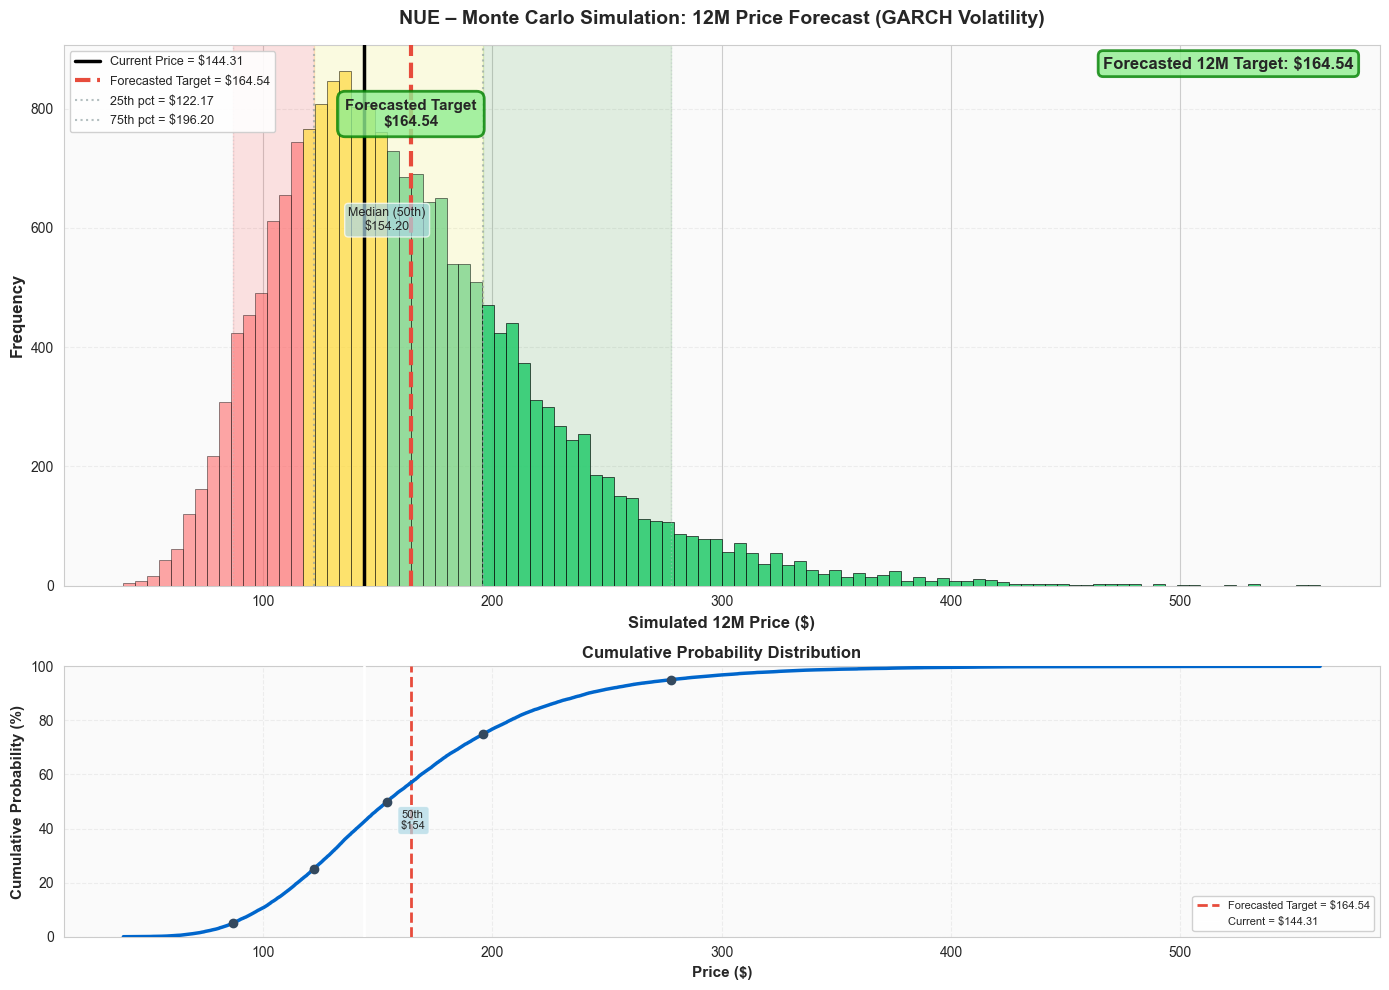


Monte Carlo Simulation Summary - NUE (GARCH Volatility)
Current Price:              $144.31
Forecasted 12M Target:      $164.54
Expected Return:            +14.02%

Volatility Model:
  Average GARCH Forecast:  35.13%
  Historical Constant:      35.42%

Simulation Results (20,000 simulations):
  Expected Value (Mean):   $164.54  ← Forecasted Target
  Median (50th):            $154.20

Price Distribution:
  5th Percentile:           $86.89
  25th Percentile:          $122.17
  75th Percentile:         $196.20
  95th Percentile:          $277.79

Upside/Downside Analysis:
  Upside Potential (75th):  35.96%
  Downside Risk (25th):     15.34%
  Risk/Reward Ratio:       2.34


In [60]:
# Enhanced Monte Carlo Visualization with GARCH Volatility Forecast
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), height_ratios=[2, 1])

# Top panel: Enhanced histogram with probability bands
n, bins, patches = ax1.hist(final_prices, bins=100, alpha=0.7, edgecolor="black", linewidth=0.5, color='#0066CC', zorder=3)

# Color bars based on probability zones
for i, (bar, bin_left, bin_right) in enumerate(zip(patches, bins[:-1], bins[1:])):
    if bin_right <= p25:
        bar.set_facecolor('#FF6B6B')  # Red for low probability
        bar.set_alpha(0.6)
    elif bin_right <= p50:
        bar.set_facecolor('#FFD93D')  # Yellow for below median
        bar.set_alpha(0.7)
    elif bin_right <= p75:
        bar.set_facecolor('#6BCF7F')  # Light green for above median
        bar.set_alpha(0.7)
    else:
        bar.set_facecolor('#2ECC71')  # Green for above forecasted target
        bar.set_alpha(0.9)

# Add vertical lines for key percentiles
ax1.axvline(current_price, linestyle='-', linewidth=2.5, color='black', 
           label=f'Current Price = ${current_price:.2f}', zorder=5)
ax1.axvline(forecasted_target_12m, linestyle='--', linewidth=3, color='#E74C3C', 
           label=f'Forecasted Target = ${forecasted_target_12m:.2f}', zorder=5)
ax1.axvline(p25, linestyle=':', linewidth=1.5, color='#95A5A6', alpha=0.7, 
           label=f'25th pct = ${p25:.2f}', zorder=4)
ax1.axvline(p75, linestyle=':', linewidth=1.5, color='#95A5A6', alpha=0.7, 
           label=f'75th pct = ${p75:.2f}', zorder=4)
ax1.axvline(p5, linestyle=':', linewidth=1, color='#BDC3C7', alpha=0.5, zorder=3)
ax1.axvline(p95, linestyle=':', linewidth=1, color='#BDC3C7', alpha=0.5, zorder=3)

# Fill probability zones
ax1.axvspan(p5, p25, alpha=0.1, color='red', zorder=1)
ax1.axvspan(p25, p75, alpha=0.1, color='yellow', zorder=1)
ax1.axvspan(p75, p95, alpha=0.1, color='green', zorder=1)

# Add text annotations
ax1.text(forecasted_target_12m, ax1.get_ylim()[1] * 0.9, f'Forecasted Target\n${forecasted_target_12m:.2f}',
        ha='center', va='top', fontsize=11, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8, edgecolor='green', linewidth=2), zorder=6)

ax1.text(p50, ax1.get_ylim()[1] * 0.7, f'Median (50th)\n${p50:.2f}',
        ha='center', va='top', fontsize=9,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7), zorder=6)

# Add forecast text box
forecast_text = f'Forecasted 12M Target: ${forecasted_target_12m:.2f}'
ax1.text(0.98, 0.98, forecast_text, transform=ax1.transAxes, fontsize=12, fontweight='bold',
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8, edgecolor='green', linewidth=2),
        zorder=7)

ax1.set_xlabel("Simulated 12M Price ($)", fontsize=12, fontweight='bold')
ax1.set_ylabel("Frequency", fontsize=12, fontweight='bold')
ax1.set_title(f"{TICKER} – Monte Carlo Simulation: 12M Price Forecast (GARCH Volatility)", 
             fontsize=14, fontweight='bold', pad=15)
ax1.legend(loc='upper left', fontsize=9, framealpha=0.9)
ax1.grid(True, alpha=0.3, linestyle='--', axis='y')
ax1.set_facecolor('#FAFAFA')

# Bottom panel: Cumulative probability distribution
sorted_prices = np.sort(final_prices)
cumulative_prob = np.arange(1, len(sorted_prices) + 1) / len(sorted_prices)

ax2.plot(sorted_prices, cumulative_prob * 100, linewidth=2.5, color='#0066CC', zorder=5)
ax2.axvline(forecasted_target_12m, linestyle='--', linewidth=2, color='#E74C3C', 
           label=f'Forecasted Target = ${forecasted_target_12m:.2f}', zorder=4)
ax2.axvline(current_price, linestyle='-', linewidth=2, color='white',
           label=f'Current = ${current_price:.2f}', zorder=4)

# Add percentile markers
for pct_val, pct_name in [(p5, '5th'), (p25, '25th'), (p50, '50th'), (p75, '75th'), (p95, '95th')]:
    prob_at_pct = (sorted_prices <= pct_val).sum() / len(sorted_prices) * 100
    ax2.plot(pct_val, prob_at_pct, 'o', color='#34495E', markersize=6, zorder=6)
    if pct_name == '50th':
        ax2.annotate(f'{pct_name}\n${pct_val:.0f}', (pct_val, prob_at_pct),
                    xytext=(10, -20), textcoords='offset points', fontsize=8,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7), zorder=7)

ax2.set_xlabel("Price ($)", fontsize=11, fontweight='bold')
ax2.set_ylabel("Cumulative Probability (%)", fontsize=11, fontweight='bold')
ax2.set_title("Cumulative Probability Distribution", fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(loc='lower right', fontsize=8, framealpha=0.9)
ax2.set_facecolor('#FAFAFA')
ax2.set_ylim([0, 100])

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n{'='*80}")
print(f"Monte Carlo Simulation Summary - {TICKER} (GARCH Volatility)")
print(f"{'='*80}")
print(f"Current Price:              ${current_price:.2f}")
print(f"Forecasted 12M Target:      ${forecasted_target_12m:.2f}")
print(f"Expected Return:            {((forecasted_target_12m/current_price - 1)*100):+.2f}%")
print(f"\nVolatility Model:")
print(f"  Average GARCH Forecast:  {avg_garch_vol:.2%}")
print(f"  Historical Constant:      {hist_annual_vol:.2%}")
print(f"\nSimulation Results ({num_sims:,} simulations):")
print(f"  Expected Value (Mean):   ${final_prices.mean():.2f}  ← Forecasted Target")
print(f"  Median (50th):            ${p50:.2f}")
print(f"\nPrice Distribution:")
print(f"  5th Percentile:           ${p5:.2f}")
print(f"  25th Percentile:          ${p25:.2f}")
print(f"  75th Percentile:         ${p75:.2f}")
print(f"  95th Percentile:          ${p95:.2f}")
print(f"\nUpside/Downside Analysis:")
upside_potential = (p75 - current_price) / current_price
downside_risk = (current_price - p25) / current_price
print(f"  Upside Potential (75th):  {upside_potential:.2%}")
print(f"  Downside Risk (25th):     {downside_risk:.2%}")
print(f"  Risk/Reward Ratio:       {upside_potential / downside_risk:.2f}")
print(f"{'='*80}")